In [80]:
import cmath
import control
from control.matlab import step
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import sympy as sp

In [81]:
A = np.array([[0, 1], [-3, -2]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])
print(A)
print(B)
print(C)

[[ 0  1]
 [-3 -2]]
[[0]
 [1]]
[[1 0]]


In [82]:
G = control.ss(A,B,C,D)
G

<LinearIOSystem:sys[17]:['u[0]']->['y[0]']>

In [83]:
system = control.ss2tf(G)
system

TransferFunction(array([-2.22044605e-16,  1.00000000e+00]), array([1., 2., 3.]))

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


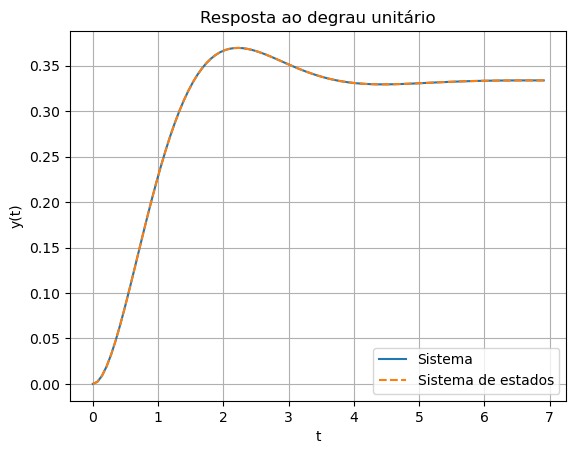

In [84]:
x, y = control.step_response(system)
x2, y2 = control.step_response(G)
plt.figure()
plt.plot(x, y, label='Sistema')
plt.plot(x2, y2, ls= '--', label='Sistema de estados')
plt.title("Resposta ao degrau unitário")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# Verificando polos da planta
eigenvalues, eigenvectors = linalg.eig(A);
poles = eigenvalues
print(poles)

[-1.+1.41421356j -1.-1.41421356j]


In [86]:
# Não é possível realizarmos uma ação de controle em sistemas não lineares, por isso essa verificação

# Matriz de Controlabilidade
Mc = control.ctrb(A,B)
Mc

# Teste de Controlabilidade
rank_Mc = np.linalg.matrix_rank(Mc, 1e-12) 

if len(Mc) == rank_Mc:          
    print("O sistema é controlável")

O sistema é controlável


In [87]:
# Autovalores Desejados
u1 = -2;
u2 = -3;

In [88]:
# Equação característica desejada
eq_des = np.poly([u1, u2]);
eq_des

array([1., 5., 6.])

In [89]:
# Substituição da matriz A no polinômio desejado phi(A)
phi_A = A**2-5*A+6*np.eye(2)  

In [90]:
K = control.acker(A,B,[u1, u2])
K

matrix([[3., 3.]])

In [91]:
# Verificação dos Autovalores
eq_car = np.poly(A-B*K)
np.roots(eq_car)


array([-3., -2.])

In [92]:
eq_car

array([1., 5., 6.])

In [93]:
# Matrizes Expandidas
A_controle = np.block([[A, np.zeros([2,1])],[-C, 0]]);
B_controle = np.block([[B],[0]]);

# Matriz de ganhos do controlador K_chapeu = [k1 k2 -ki]
K_controle = control.acker(A_controle,B_controle,[u1, u2])
K_controle

#Utilizando a formula do slide para termos o sistema expandido
Ki = -K_controle[0,2]
AA = np.block([[A-B*K, B*Ki],[-C,0]])
BB = np.block([[0],[0],[1]])
CC = np.block([1, 0, 0])
DD = 0;

controlled_sys = control.ss(AA,BB,CC,DD);

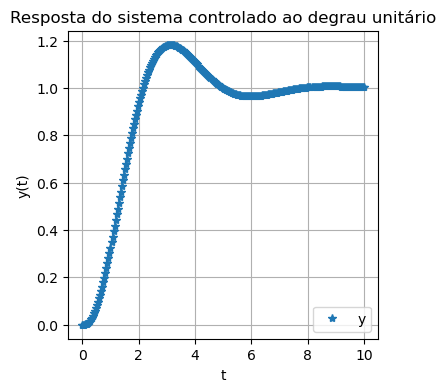

In [94]:
# resposta para entrada ao degrau do sistema controlado
tfinal = 10
Y_ctrld, t_y_ctrld = control.matlab.step(controlled_sys,tfinal);

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(4,4)

ax1.plot(t_y_ctrld,Y_ctrld,'*')
ax1.set_title("Resposta do sistema controlado ao degrau unitário")
ax1.set_xlabel("t")
ax1.set_ylabel("y(t)")
ax1.legend(['y'],loc="lower right")
ax1.grid(True,'both')

In [95]:
#  Condições Iniciais
x0 = np.matrix('1; 1');
# entrada nula - u
t = np.linspace(0, 30, 1000);
u = np.zeros(len(t));
# resposta para entrada nula
Y, t, X = control.matlab.lsim(system,u,t,x0);

C:\Users\Aluno\AppData\Roaming\Python\Python39\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Aluno\AppData\Roaming\Python\Python39\site-packages\control\timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


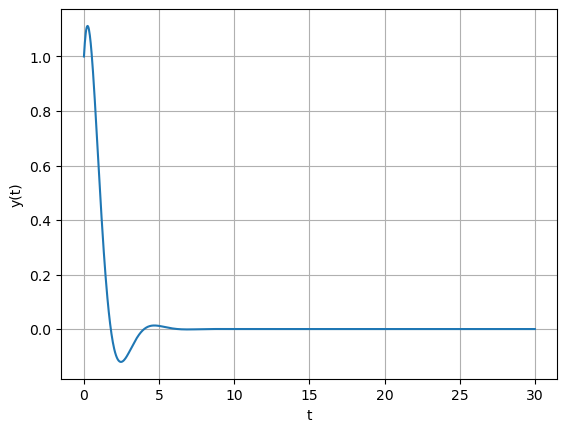

In [96]:
# comportamento da saída y                      
plt.figure()
plt.plot(t, Y)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.grid(True)
plt.show()

In [97]:
# separando os elemntos do vetor X
x1a = X[:,0];
x1b = X[:,1];

In [98]:
T = 0.1;
tfinal = 30;
Kmax = int(tfinal/T+1);
k = np.linspace(0, Kmax, Kmax+1)
u = np.zeros(len(k));

In [99]:
x1 = np.zeros(len(k));
x2 = np.zeros(len(k));
x1_ponto = np.zeros(len(k));
x2_ponto = np.zeros(len(k));
y = np.zeros(len(k));

# condições iniciais (podem ser diferentes de zero)
x1[0] = x0[0];  #  para k = 0
x2[0] = x0[1];  #  para k = 0
x1_ponto[0] = 0;  #  para k = 0
x2_ponto[0] = 0;  #  para k = 0
y[0] = C[0,0]*x1[0]+C[0,1]*x2[0]+D*u[0];  #  para k = 0

In [100]:
    for j in range(1,Kmax):
        # Equações dos integradores
        x1[j]=T*x1_ponto[j-1]+x1[j-1];
        x2[j]=T*x2_ponto[j-1]+x2[j-1];    
        # Equação diferencial de estados:  Xponto=A*X+B*U
        x1_ponto[j]=A[0,0]*x1[j]+A[0,1]*x2[j]*u[j];  
        x2_ponto[j]=A[1,0]*x1[j]+A[1,1]*x2[j]*u[j]; 
        # Equação de Saída: Y=C*X+D*U
        y[j] = C[0,0]*x1[j]+C[0,1]*x2[j]+D*u[j];

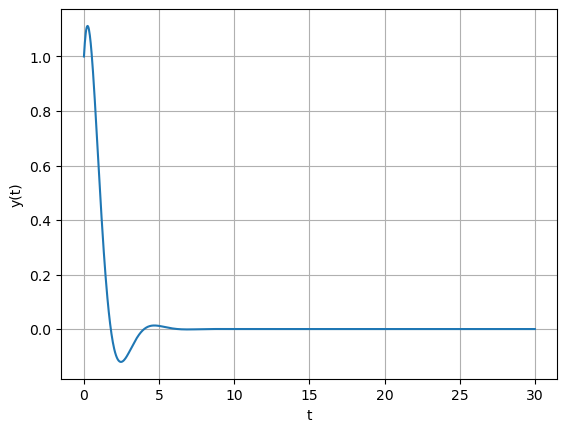

In [101]:
# comportamento da saída y                      
plt.figure()
plt.plot(t, Y)
plt.xlabel("t")
plt.ylabel("y(t)")
plt.grid(True)
plt.show()

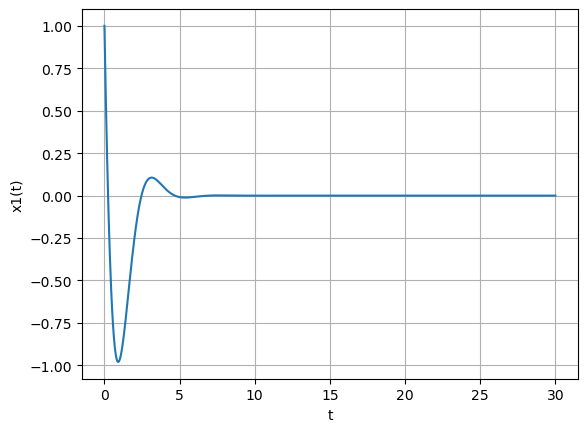

In [102]:
# comportamento do estado x1                       
plt.figure()
plt.plot(t, x1a)
plt.xlabel("t")
plt.ylabel("x1(t)")
plt.grid(True)
plt.show()

In [103]:
X0 = [[1], [0]];
X0 = np.matrix(X0)

# Solução com a transformada de laplace
#s, t = sp.symbols('s t')
s = sp.symbols('s')
t = sp.symbols('t', positive=True)

# Matrizes
A = sp.Matrix(A);
B = sp.Matrix(B);
C = sp.Matrix(C);
D = sp.Matrix(D);
X0 = sp.Matrix(X0);
I = np.eye(2);

X = ((s*I-A)**-1)*X0+((s*I-A)**-1)*B*U;
Y = C*X;
Y = sp.expand(Y)
Y = sp.simplify(Y)
Y = Y.apart(s)
Y

Matrix([[0.5*(0.333333333333333*s + 1.0)/(0.333333333333333*s**2 + 0.666666666666667*s + 1.0) + 0.5/(s + 1)]])

In [113]:
F1 = (0.5*(0.333333333*s+1));
F3 = 1/((0.33333333*s**2)+(0.6666666667*s+1));
F2 = 0.5/(s+1);

y1 = sp.inverse_laplace_transform(F1, s, t)
y2 = sp.inverse_laplace_transform(F2, s, t)
y3 = sp.inverse_laplace_transform(F3, s, t)

y = y1*y2+y3
y = sp.simplify(y)
y

((2.12132035952258*sin(1.41421356587327*t) + 7.48377541792165e-16*cos(1.41421356587327*t))*exp(t) + 0.08333333325*InverseLaplaceTransform(s, s, t, _None)*exp(1.00000001005*t))*exp(-2.00000001005*t)

In [ ]:
y1 = 